# **Redes Neurais**
## **Modelo 1 - Rede MLP**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

### **Instruções**

- Selecionar dois datasets (não triviais)
    - Um dataset para classificação
    - Um dataset para regressão

- Separar em treino/validação/teste
- Treinar modelos MLP para os dois problemas

- Considerar:
    - Diferentes topologias (>=5 topologias, variar número de camadas)
    - Usar o algoritmo original SGD (não usar algoritmos otimizados, e.g. ADAM)
    - Avaliar o impacto do uso do Momentum
    - Avaliar o impacto do uso da regularização (i.e. L2)

- Ilustrar graficamente a evolução do treinamento (treino/validação).
- Confeccionar um relatório (reprodutível) contendo os experimentos e resultados

### **1. Datasets escolhidos**

#### **Classificação: MNIST**
**Fonte**: `keras.datasets.mnist` | [Original: Yann LeCun](http://yann.lecun.com/exdb/mnist/)
- Ano: 1998
- Samples: 70.000 (60k treino + 10k teste)
- Features: 784 (28x28 pixels)
- Target: 10 classes (dígitos 0-9)

#### **Regressão: California Housing**  
**Fonte**: `sklearn.datasets.fetch_california_housing` | [Census 1990](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
- Ano: 1997
- Samples: 20.640
- Features: 8
    - MedInc - Median income in block group
    - HouseAge - Median house age in block group
    - AveRooms - Average number of rooms per household
    - AveBedrms - Average number of bedrooms per household
    - Population - Block group population
    - AveOccup - Average number of household members
    - Latitude - Block group latitude
    - Longitude - Block group longitude
- Target: MedHouseVal (valor mediano das casas)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import History
from keras.datasets import mnist

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.20.0
Keras version: 3.11.3


## **2. Classificação - MNIST**

### **2.1. Carregamento e Pré-processamento**
Carregamento do MNIST, normalização dos pixels (0-1) e preparação dos dados para treinamento.

Foram escolhidos 48000 dados para Treino, 12000 para Validação, e 10000 para Teste.

In [12]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], -1).astype('float32') / 255.0
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], -1).astype('float32') / 255.0

X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    X_train_mnist, y_train_mnist, test_size=0.2, random_state=42, stratify=y_train_mnist
)

print(f"Train: {X_train_mnist.shape}, Val: {X_val_mnist.shape}, Test: {X_test_mnist.shape}")
print(f"Pixel range: [{X_train_mnist.min():.1f}, {X_train_mnist.max():.1f}]")
print(f"Classes: {np.unique(y_train_mnist)}")

Train: (48000, 784), Val: (12000, 784), Test: (10000, 784)
Pixel range: [0.0, 1.0]
Classes: [0 1 2 3 4 5 6 7 8 9]


### **2.2. Visualização dos Dados**
Análise visual dos dígitos e distribuição das classes.

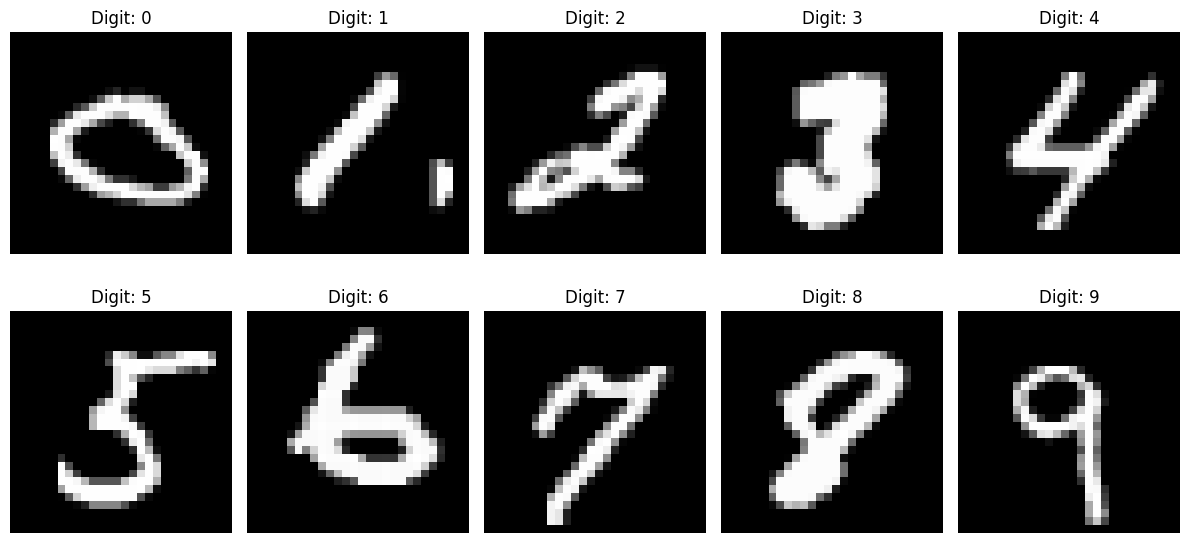

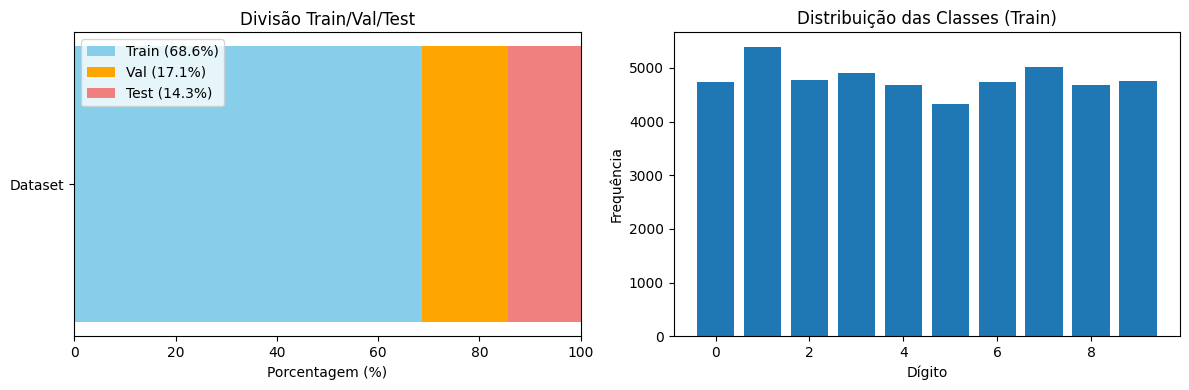

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_train_mnist == i)[0][0]
    img = X_train_mnist[idx].reshape(28, 28)
    axes[i//5, i%5].imshow(img, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit: {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4))

unique, counts = np.unique(y_train_mnist, return_counts=True)
ax1.bar(unique, counts)
ax1.set_title('Distribuição das Classes (Train)')
ax1.set_xlabel('Dígito')
ax1.set_ylabel('Frequência')

total_samples = len(X_train_mnist) + len(X_val_mnist) + len(X_test_mnist)
train_pct = len(X_train_mnist) / total_samples * 100
val_pct = len(X_val_mnist) / total_samples * 100
test_pct = len(X_test_mnist) / total_samples * 100

ax2.barh(['Dataset'], [train_pct], left=0, label=f'Train ({train_pct:.1f}%)', color='skyblue')
ax2.barh(['Dataset'], [val_pct], left=train_pct, label=f'Val ({val_pct:.1f}%)', color='orange')
ax2.barh(['Dataset'], [test_pct], left=train_pct+val_pct, label=f'Test ({test_pct:.1f}%)', color='lightcoral')
ax2.set_xlabel('Porcentagem (%)')
ax2.set_title('Divisão Train/Val/Test')
ax2.legend()
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()

### **2.3. Configuração dos Experimentos**
5 topologias diferentes com análise de Stochastic Gradient Descent (SGD), Momentum e Regularização L2.

Serão feitos **9** experimentos:

- 1 Camada:
    - 4 neurônios: [4] → 10
    - 16 neurônios: [16] → 10
    - 64 neurônios: [64] → 10

- 2 Camadas:
    - [4, 4] → 10
    - [16, 4] → 10
    - [4, 16] → 10 
    - [32, 64] → 10
    - [64, 32] → 10

- 3 Camadas:
    - [64, 32, 16] → 10

In [14]:
topologies = [
    ("1 camada, 4 neurônios", [4]),
    ("1 camada, 16 neurônios", [16]),
    ("1 camada, 64 neurônios", [64]),
    ("2 camadas, 4-4", [4, 4]),
    ("2 camadas, 16-4", [16, 4]),
    ("2 camadas, 4-16", [4, 16]),
    ("2 camadas, 32-64", [32, 64]),
    ("2 camadas, 64-32", [64, 32]),
    ("3 camadas, 64-32-16", [64, 32, 16])
]

configurations = [
    ("SGD", {"use_momentum": False, "use_l2": False}),
    ("SGD + Momentum", {"use_momentum": True, "use_l2": False}),
    ("SGD + L2", {"use_momentum": False, "use_l2": True}),
    ("SGD + Momentum + L2", {"use_momentum": True, "use_l2": True})
]

### **2.4. Função para Criar e Treinar Modelos**
Função auxiliar para criação de MLPs com diferentes configurações.

In [ ]:
def create_mlp_model(layers, use_momentum=False, use_l2=False):
    model = Sequential()
    
    for i, neurons in enumerate(layers):
        if i == 0:
            if use_l2:
                model.add(Dense(neurons, activation='relu', input_shape=(784,), 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu', input_shape=(784,)))
        else:
            if use_l2:
                model.add(Dense(neurons, activation='relu', 
                               kernel_regularizer=l2(0.001)))
            else:
                model.add(Dense(neurons, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    
    if use_momentum:
        optimizer = SGD(learning_rate=0.01, momentum=0.9)
    else:
        optimizer = SGD(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def train_and_evaluate(model, model_name, epochs=50):
    import time
    start_time = time.time()
    
    history = model.fit(X_train_mnist, y_train_mnist,
                       validation_data=(X_val_mnist, y_val_mnist),
                       epochs=epochs, batch_size=128, verbose=0)
    
    training_time = time.time() - start_time

    val_loss = min(history.history['val_loss'])
    val_acc = max(history.history['val_accuracy'])
    
    return history, val_acc, val_loss, training_time

: 

### **2.5. Todas as Topologias - Comparação**
Treinamento de todas as 9 topologias com SGD básico para comparação.

In [ ]:
all_results = []

for i, (topo_name, layers) in enumerate(topologies, 1):
    print(f"Topologia {i}: {topo_name}")
    
    config = {"use_momentum": False, "use_l2": False}
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"topo_{i}")
    
    result = {
        'name': topo_name,
        'layers': layers,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model,
        'topology_id': i
    }
    
    all_results.append(result)
    
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s\n")

print("Treinamento concluído!")

Topologia 1: 1 camada, 4 neurônios


/home/tales/unifesp/neural_networks/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Val Acc: 0.8486 | Val Loss: 0.5474 | Tempo: 48.80s

Topologia 2: 1 camada, 16 neurônios
  Val Acc: 0.9285 | Val Loss: 0.2490 | Tempo: 50.42s

Topologia 3: 1 camada, 64 neurônios
  Val Acc: 0.9285 | Val Loss: 0.2490 | Tempo: 50.42s

Topologia 3: 1 camada, 64 neurônios
  Val Acc: 0.9463 | Val Loss: 0.1953 | Tempo: 55.15s

Topologia 4: 2 camadas, 4-4
  Val Acc: 0.9463 | Val Loss: 0.1953 | Tempo: 55.15s

Topologia 4: 2 camadas, 4-4
  Val Acc: 0.7329 | Val Loss: 0.8679 | Tempo: 46.22s

Topologia 5: 2 camadas, 16-4
  Val Acc: 0.7329 | Val Loss: 0.8679 | Tempo: 46.22s

Topologia 5: 2 camadas, 16-4
  Val Acc: 0.9213 | Val Loss: 0.2882 | Tempo: 49.84s

Topologia 6: 2 camadas, 4-16
  Val Acc: 0.9213 | Val Loss: 0.2882 | Tempo: 49.84s

Topologia 6: 2 camadas, 4-16
  Val Acc: 0.8579 | Val Loss: 0.4743 | Tempo: 47.86s

Topologia 7: 2 camadas, 32-64
  Val Acc: 0.8579 | Val Loss: 0.4743 | Tempo: 47.86s

Topologia 7: 2 camadas, 32-64
  Val Acc: 0.9523 | Val Loss: 0.1684 | Tempo: 52.38s

Topologia 8:

### **2.6. Análise Comparativa das Topologias**
Identificação da melhor e pior topologia para análise detalhada.

In [ ]:
results_df = pd.DataFrame([{
    'Topologia': r['name'],
    'Val_Accuracy': r['val_acc'],
    'Val_Loss': r['val_loss'], 
    'Tempo_Treino': r['training_time'],
    'ID': r['topology_id']
} for r in all_results])

results_df = results_df.sort_values('Val_Accuracy', ascending=False)

best_topology = all_results[results_df.iloc[0]['ID'] - 1]
worst_topology = all_results[results_df.iloc[-1]['ID'] - 1]

print(f"\nMELHOR: {best_topology['name']} - Val Acc: {best_topology['val_acc']:.4f}")
print(f"\nPIOR: {worst_topology['name']} - Val Acc: {worst_topology['val_acc']:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(range(len(all_results)), [r['val_acc'] for r in all_results])
axes[0].set_title('Acurácia de Validação')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(all_results)))
axes[0].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

axes[1].bar(range(len(all_results)), [r['val_loss'] for r in all_results])
axes[1].set_title('Loss de Validação')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(len(all_results)))
axes[1].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

axes[2].bar(range(len(all_results)), [r['training_time'] for r in all_results])
axes[2].set_title('Tempo de Treinamento')
axes[2].set_ylabel('Segundos')
axes[2].set_xticks(range(len(all_results)))
axes[2].set_xticklabels([f"T{i+1}" for i in range(len(all_results))], rotation=45)

plt.tight_layout()
plt.show()

### **2.7. Análise Detalhada: Melhor Topologia**
Variação de SGD, Momentum e L2 na melhor topologia.

In [ ]:
best_detailed_results = []
layers = best_topology['layers']

for config_name, config in configurations:
    print(f"Treinando: {config_name}")
    
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"best_{config_name}")
    
    best_detailed_results.append({
        'config': config_name,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model
    })
    
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for result in best_detailed_results:
    axes[0].plot(result['history'].history['loss'], label=f"{result['config']} (Train)")
    axes[0].plot(result['history'].history['val_loss'], linestyle='--', label=f"{result['config']} (Val)")

axes[0].set_title(f'Loss - {best_topology["name"]}')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Loss')
axes[0].legend()

for result in best_detailed_results:
    axes[1].plot(result['history'].history['accuracy'], label=f"{result['config']} (Train)")
    axes[1].plot(result['history'].history['val_accuracy'], linestyle='--', label=f"{result['config']} (Val)")

axes[1].set_title(f'Accuracy - {best_topology["name"]}')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### **2.8. Análise Detalhada: Pior Topologia**
Variação de SGD, Momentum e L2 na pior topologia.

In [ ]:
worst_detailed_results = []
layers = worst_topology['layers']

for config_name, config in configurations:
    print(f"Treinando: {config_name}")
    
    model = create_mlp_model(layers, **config)
    history, val_acc, val_loss, training_time = train_and_evaluate(model, f"worst_{config_name}")
    
    worst_detailed_results.append({
        'config': config_name,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'model': model
    })
    
    print(f"  Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | Tempo: {training_time:.2f}s")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for result in worst_detailed_results:
    axes[0].plot(result['history'].history['loss'], label=f"{result['config']} (Train)")
    axes[0].plot(result['history'].history['val_loss'], linestyle='--', label=f"{result['config']} (Val)")

axes[0].set_title(f'Loss - {worst_topology["name"]}')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Loss')
axes[0].legend()

for result in worst_detailed_results:
    axes[1].plot(result['history'].history['accuracy'], label=f"{result['config']} (Train)")
    axes[1].plot(result['history'].history['val_accuracy'], linestyle='--', label=f"{result['config']} (Val)")

axes[1].set_title(f'Accuracy - {worst_topology["name"]}')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### **2.9. Avaliação Final no Conjunto de Teste**
Teste apenas do melhor modelo para evitar contaminação das amostras.

In [ ]:
best_model_config = max(best_detailed_results, key=lambda x: x['val_acc'])
final_model = best_model_config['model']

test_loss, test_acc = final_model.evaluate(X_test_mnist, y_test_mnist, verbose=0)

y_pred = final_model.predict(X_test_mnist, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cm = confusion_matrix(y_test_mnist, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Matriz de Confusão - Modelo Final')
ax1.set_xlabel('Predito')
ax1.set_ylabel('Real')

metrics_data = {
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Val Accuracy': best_model_config['val_acc'],
    'Val Loss': best_model_config['val_loss']
}

ax2.bar(range(len(metrics_data)), list(metrics_data.values()))
ax2.set_title('Métricas do Modelo Final')
ax2.set_xticks(range(len(metrics_data)))
ax2.set_xticklabels(list(metrics_data.keys()), rotation=45)
ax2.set_ylabel('Valor')

plt.tight_layout()
plt.show()